In [15]:
from torch import nn
import torch, gym, gym_unbalanced_disk, time, gym.wrappers
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy
import os
from matplotlib import pyplot as plt

In [16]:
class Qfunction(nn.Module):
    def __init__(self, env):
        super(Qfunction,self).__init__()
        self.lay1 = nn.Linear(env.observation_space.shape[0], 40)
        self.F1 =  nn.Tanh() #a)
        self.lay2 = nn.Linear(40,env.action_space.n)
    
    def forward(self, obs):
        return self.lay2(self.F1(self.lay1(obs)))

In [17]:
def show(Q,env,setting):
    u = []
    theta = []
    omega = []
    with torch.no_grad():
        #you can use Qfun(obs) as a shorthand for the q function.
        Qfun = lambda x: Q(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy() #convert x to torch.tensor -> put in the Q function -> back to numpy
        try:
            obs = env.reset() #b)
            env.render() #b)
            time.sleep(1) #b)
            while True: #b)
                action = np.argmax(Qfun(obs)) #b)
                obs, reward, done, info = env.step(action) #b)
                time.sleep(1/60) #b)
                env.render() #b)
                if setting == "u":
                    print(env.u)
                elif setting == 'omega':
                    print(env.omega)
                elif setting == 'theta':
                    print(env.th)
                u.append(env.u)
                theta.append(env.th)
                omega.append(env.omega)
                if done: #b)
                    time.sleep(0.5)  #b)
                    break  #b)
        finally: #this will always run even when an error occurs
            env.close()
            return u,theta,omega
        

def eval_Q(Q,env):
    with torch.no_grad():
        Qfun = lambda x: Q(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy()
        rewards_acc = 0 #d)
        obs = env.reset() #d)
        while True: #d)
            action = np.argmax(Qfun(obs)) #d)
            obs, reward, done, info = env.step(action) #d)
            rewards_acc += reward #d)
            if done: #d)
                return rewards_acc #d)

In [18]:
max_episode_steps = 300
env = gym.make('unbalanced-disk-sincos-v0', dt=0.025, umax=3.)
env = gym.wrappers.time_limit.TimeLimit(env,max_episode_steps=max_episode_steps)

In [19]:
# env.set_discrete_values(discrete_size = 9, minmax = 3.0, div = 2.5, rnd = 2)
env.set_discrete_values_manual([-3.0, -1.5, -0.5, -0.2, -0.1, 0, 0.1, 0.2, 0.5, 1.5, 3.0])

Discrete value set changed to [-3.0, -1.5, -0.5, -0.2, -0.1, 0, 0.1, 0.2, 0.5, 1.5, 3.0]


In [20]:
# # Load the .npy file with allow_pickle=True
# Q = np.load('Qfunction.npz')

# Create an instance of Qfunction
Q = Qfunction(env)

# Load Q from the saved file
Q.load_state_dict(torch.load('Qfunction2.pt'))

<All keys matched successfully>

In [21]:
u,theta,omega = show(Q,env,'theta')

0.023527494301096394
0.0927795827199937
0.20033194909830185
0.33659737528045713
0.49035722073749555
0.6500242349584942
0.8048766682423292
0.9459870701773573
1.0666746099999902
1.1624898159731625
1.2308823611690694
1.2707471819019442
1.2820746006112307
1.2701763894046376
1.2388226925345454
1.1894314710912819
1.1239694129834668
1.0450567397861663
0.9300641715668371
0.7595472072006759
0.5443304176902412
0.29935363359404765
0.04306847331171082
-0.20447769404613952
-0.42433522388883005
-0.6010432757553652
-0.7238835155759002
-0.7869388898199544
-0.7898214926785592
-0.7139449344347188
-0.5412100178502242
-0.2859189720423413
0.03085960962968215
0.38270046670470304
0.7418519454768295
1.084560143051743
1.3950006773284298
1.666181538175775
1.89834299503131
2.096442242811772
2.2679596983438666
2.421492577757751
2.5661012312182647
2.7112128584732176
2.8669027839075323
3.0444296634441743
3.256922617077606
3.5200427773286185
3.8521660630213663
4.273012355485491
4.79876285250883
5.431930623908495
6.1

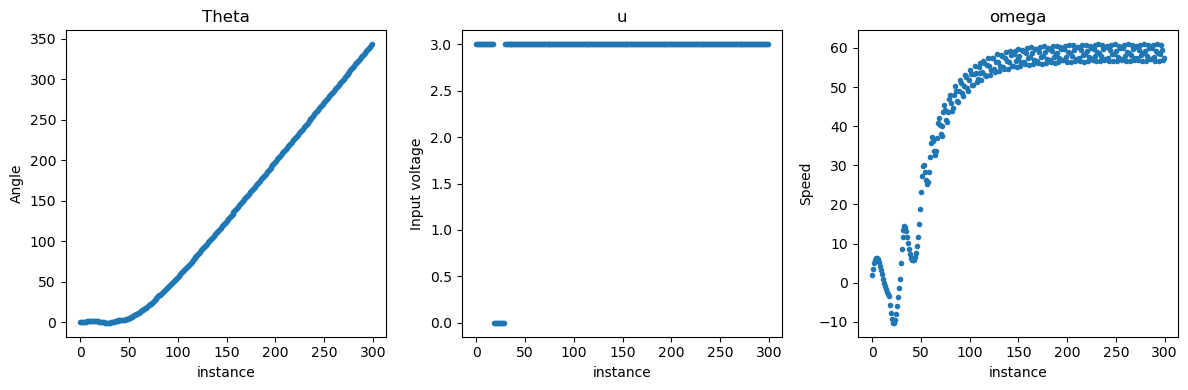

In [22]:
# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot theta
axs[0].plot(theta, '.')
axs[0].set_title('Theta')
axs[0].set_xlabel('instance')
axs[0].set_ylabel('Angle')

# Plot u
axs[1].plot(u, '.')
axs[1].set_title('u')
axs[1].set_xlabel('instance')
axs[1].set_ylabel('Input voltage')

# Plot omega
axs[2].plot(omega, '.')
axs[2].set_title('omega')
axs[2].set_xlabel('instance')
axs[2].set_ylabel('Speed')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [23]:
eval_Q(Q,env)

51.723228057780275

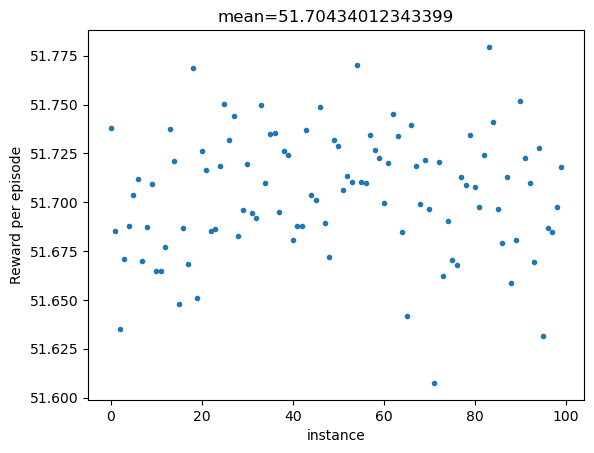

In [24]:
Rewards = [eval_Q(Q,env) for i in range(100)]
plt.plot(Rewards,'.')
plt.title(f'mean={np.mean(Rewards)}')
plt.xlabel('instance')
plt.ylabel('Reward per episode')
plt.show()

In [25]:
def argmax(a):
    #argmax([0,1,2,3]) -> 3
    #argmax([0,1,2,2]) -> 2 or 3 with equal probability of both (np.argmax would only return 2)
    #argmax([0,0,0,0]) -> 0, 1, 2 or 3 with equal probability of each (np.argmax would only return 0)
    a = np.array(a)
    return np.random.choice(np.arange(a.shape[0],dtype=int)[a==np.max(a)])

In [26]:
def make_radial_basis_network(env,nvec,scale):
    # env: is the given enviroment
    # nvec: is the given number of grid points in each dimention.
    # scale: is the sigma_c in the equation
    if isinstance(nvec,int):
        nvec = [nvec]*env.observation_space.shape[0]
    
    # This creates a grid of points c_i the lower bound to the upper bound with nvec number of samples in each dimention
    low, high = env.observation_space.low, env.observation_space.high # get upper and lower bound
    assert np.all(np.isfinite(low)) and np.all(np.isfinite(high)), f'infinite bounds on obersvation space are not permitted low={low}, high={high}'
    Xvec = [np.linspace(l,h,num=ni) for l,h,ni in zip(low,high,nvec)] # calculate the linspace in all directions
    c_points = np.array(np.meshgrid(*Xvec)) # meshgrid all the linspaces together (Nx, X1, X2, X3, ...) 
    c_points = np.moveaxis(c_points, 0, -1) #transform to (X1, X2, X3, ..., Nobs) 
    c_points = c_points.reshape((-1,c_points.shape[-1])) #flatten into the size (Nc, Nobs)
    dx = np.array([X[1]-X[0] for X in Xvec]) # spacing (related to the B matrix)
    
    def basis_fun(obs):
        #this function should return the vector containing all phi_i of all c_points
        obs = np.array(obs) #(Nobs)
        
        dis = (c_points-obs[None,:])/dx[None,:] #dim = (Nbasis, Nobs)
        exp_arg = np.sum(dis**2,axis=1)/(2*scale**2) #squared distance to every point #b)
        Z = -exp_arg+np.min(exp_arg) #b) for numerical stability you can add the minimum.
        R = np.exp(Z) #b)
        return R/np.sum(R) #b)
    
    return basis_fun #returns a basis function

In [27]:
def visualize_theta(env, theta, basis_fun):
    # for a given enviroment, theta matrix (Nbasis, Naction) and basis_fun(obs) -> (Nbasis,) 
    # it visualizes the max Q value in state-space.
    low, high = env.observation_space.low, env.observation_space.high
    nvec = [50,60]
    Xvec = [np.linspace(l,h,num=ni) for l,h,ni in zip(low,high,nvec)] # calculate the linspace in all directions
    c_points = np.array(np.meshgrid(*Xvec)) # meshgrid all the linspaces together (Nx, X1, X2, X3, ...) 
    c_points = np.moveaxis(c_points, 0, -1) #transform to (X1, X2, X3, ..., Nobs) 
    c_points = c_points.reshape((-1,c_points.shape[-1])) #flatten into the size (Nc, Nobs)
    maxtheta = np.array([np.max(basis_fun(ci)@theta) for ci in c_points]).reshape((nvec[1],nvec[0]))
    
    plt.contour(Xvec[0],Xvec[1],maxtheta)
    plt.xlabel('position')
    plt.ylabel('velocity')
    plt.colorbar()
    plt.show()

In [28]:
def roll_mean(ar,start=400,N=25):
    s = 1-1/N
    k = start
    out = np.zeros(ar.shape)
    for i,a in enumerate(ar):
        k = s*k + (1-s)*a
        out[i] = k
    return out

In [29]:
nvec = 10
scale = 0.5
basis_fun = make_radial_basis_network(env,nvec,scale=scale) #e)

In [30]:
class Qfunction(nn.Module):
    def __init__(self, env):
        super(Qfunction,self).__init__()
        self.lay1 = nn.Linear(env.observation_space.shape[0], 40)
        self.F1 =  nn.Tanh() #a)
        self.lay2 = nn.Linear(40,env.action_space.n)
    
    def forward(self, obs):
        return self.lay2(self.F1(self.lay1(obs)))
    
def show(Q,env,setting):
    u = []
    theta = []
    omega = []
    with torch.no_grad():
        #you can use Qfun(obs) as a shorthand for the q function.
        Qfun = lambda x: Q(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy() #convert x to torch.tensor -> put in the Q function -> back to numpy
        try:
            obs = env.reset() #b)
            env.render() #b)
            time.sleep(1) #b)
            while True: #b)
                action = np.argmax(Qfun(obs)) #b)
                obs, reward, done, info = env.step(action) #b)
                time.sleep(1/60) #b)
                env.render() #b)
                if setting == "u":
                    print(env.u)
                elif setting == 'omega':
                    print(env.omega)
                elif setting == 'theta':
                    print(env.th)
                u.append(env.u)
                theta.append(env.th)
                omega.append(env.omega)
                if done: #b)
                    time.sleep(0.5)  #b)
                    break  #b)
        finally: #this will always run even when an error occurs
            env.close()
            return u,theta,omega
        
def rollout(Q, env, epsilon=0.1, N_rollout=10_000): 
    #save the following (use .append)
    Start_state = [] #hold an array of (x_t)
    Actions = [] #hold an array of (u_t)
    Rewards = [] #hold an array of (r_{t+1})
    End_state = [] #hold an array of (x_{t+1})
    Terminal = [] #hold an array of (terminal_{t+1})
    # Qfun( a numpy array of the obs) -> a numpy array of Q values
    Qfun = lambda x: Q(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy() 
    with torch.no_grad():
        
        obs = env.reset() #c)
        for i in range(N_rollout): #c)
            if np.random.uniform()>epsilon: #c)
                Qnow = Qfun(obs) #c)
                action = np.argmax(Qnow) #c)
            else: #c)
                action = env.action_space.sample() #c)
            Start_state.append(obs) #c)
            Actions.append(action) #c)

            obs_next, reward, done, info = env.step(action) #c)
            terminal = done and not info.get('TimeLimit.truncated', False) #c)

            Terminal.append(terminal) #c)
            Rewards.append(reward) #c)
            End_state.append(obs_next) #c)

            if done: #c)
                obs = env.reset() #c)
            else: #c)
                obs = obs_next #c)
                
    #error checking:
    assert len(Start_state)==len(Actions)==len(Rewards)==len(End_state)==len(Terminal), f'error in lengths: {len(Start_state)}=={len(Actions)}=={len(Rewards)}=={len(End_state)}=={len(Dones)}'
    return np.array(Start_state), np.array(Actions), np.array(Rewards), np.array(End_state), np.array(Terminal).astype(int)

def eval_Q(Q,env):
    with torch.no_grad():
        Qfun = lambda x: Q(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy()
        rewards_acc = 0 #d)
        obs = env.reset() #d)
        while True: #d)
            action = np.argmax(Qfun(obs)) #d)
            obs, reward, done, info = env.step(action) #d)
            rewards_acc += reward #d)
            if done: #d)
                return rewards_acc #d)
            
def DQN_rollout(Q, optimizer, env, gamma=0.98, use_target_net=False, N_iterations=21, N_rollout=20000, \
                N_epochs=10, batch_size=32, N_evals=10, target_net_update_feq=100):
    best = -float('inf')
    torch.save(Q.state_dict(),'Q-checkpoint')
    ep_length = []
    scores = []
    try:
        for iteration in range(N_iterations):
            epsilon = 1.0 - iteration/(N_iterations-1) #e=) 1.
            print(f'rollout iteration {iteration} with epsilon={epsilon:.2%}...')
            
            #2. rollout
            Start_state, Actions, Rewards, End_state, Dones = rollout(Q, env, epsilon=epsilon, N_rollout=N_rollout) #e) 2.
            
            #Data conversion, no changes required
            convert = lambda x: [torch.tensor(xi,dtype=torch.float32) for xi in x]
            Start_state, Rewards, End_state, Dones = convert([Start_state, Rewards, End_state, Dones])
            Actions = Actions.astype(int)

            print('starting training on rollout information...')
            t = 0
            for epoch in range(N_epochs): 
                for i in range(batch_size,len(Start_state)+1,batch_size): 
                    if t%target_net_update_feq==0:
                        Qtarget = deepcopy(Q) #g)
                        pass
                    t += 1
                    
                    Start_state_batch, Actions_batch, Rewards_batch, End_state_batch, Dones_batch = [d[i-batch_size:i] for d in [Start_state, Actions, Rewards, End_state, Dones]] #e=) 3.
                    
                    with torch.no_grad(): #3.
                        if use_target_net:
                            maxQ = torch.max(Qtarget(End_state_batch),dim=1)[0] #g)
                        else:
                            maxQ = torch.max(Q(End_state_batch),dim=1)[0] #e=) 3.
                    
                    action_index = np.stack((np.arange(batch_size),Actions_batch),axis=0)
                    Qnow = Q(Start_state_batch)[action_index] #Q(x_t,u_t) is given
                    
                    Loss = torch.mean((Rewards_batch + gamma*maxQ*(1-Dones_batch) - Qnow)**2) #e) 3.
                    optimizer.zero_grad() #e) 3.
                    Loss.backward() #e) 3.
                    optimizer.step() #e) 3.
                
                score = np.mean([eval_Q(Q,env) for i in range(N_evals)]) #e=) 3.

                scores.append(score)
                
                print(f'iteration={iteration} epoch={epoch} Average Reward per episode:',score)
                if score>best:
                    best = score
                    print('################################# \n new best',best,'saving Q... \n#################################')
                    torch.save(Q.state_dict(),'Q-checkpoint')
            
            print('loading best result')
            Q.load_state_dict(torch.load('Q-checkpoint'))
    finally: #this will always run even when using the a KeyBoard Interrupt. 
        print('loading best result')
        Q.load_state_dict(torch.load('Q-checkpoint'))
        return scores

In [31]:
max_episode_steps = 100
env = gym.make('unbalanced-disk-sincos-v0', dt=0.025, umax=3.)
env = gym.wrappers.time_limit.TimeLimit(env,max_episode_steps=max_episode_steps)

target_angle = np.pi # target set to be balanced on top


reward_function = lambda self: ((np.cos(self.th-target_angle)+1.6)** 2 - 0.25) - 0.0025*(self.omega)** 2 - 0.0075*(self.u)**2

env.change_reward_function(reward_function)

# env.set_discrete_values(discrete_size = 9, minmax = 3.0, div = 2.5, rnd = 2)
env.set_discrete_values_manual([-3.0, -1.5, -0.5, -0.2, -0.1, 0, 0.1, 0.2, 0.5, 1.5, 3.0])


gamma = 0.98 #f=)
batch_size = 32 #f=)
N_iterations = 25 #f=)
N_rollout = 5000 #f=)
N_epochs = 3 #f=)
N_evals = 3 #f=)
lr = 0.0005 #given

assert isinstance(env.action_space,gym.spaces.Discrete), 'action space requires to be discrete'
Q = Qfunction(env)
optimizer = torch.optim.Adam(Q.parameters(),lr=lr) #low learning rate
scores = DQN_rollout(Q, optimizer, env, use_target_net=False, gamma=gamma, N_iterations=N_iterations, \
            N_rollout=N_rollout, N_epochs=N_epochs, N_evals=N_evals)

Discrete value set changed to [-3.0, -1.5, -0.5, -0.2, -0.1, 0, 0.1, 0.2, 0.5, 1.5, 3.0]
rollout iteration 0 with epsilon=100.00%...
starting training on rollout information...
iteration=0 epoch=0 Average Reward per episode: 13.940431572899096
################################# 
 new best 13.940431572899096 saving Q... 
#################################
iteration=0 epoch=1 Average Reward per episode: 30.919764908718417
################################# 
 new best 30.919764908718417 saving Q... 
#################################
iteration=0 epoch=2 Average Reward per episode: 41.408684910542284
################################# 
 new best 41.408684910542284 saving Q... 
#################################
iteration=0 epoch=3 Average Reward per episode: 43.005771854440916
################################# 
 new best 43.005771854440916 saving Q... 
#################################
iteration=0 epoch=4 Average Reward per episode: 46.581170898991616
################################# 
 new best

In [32]:
scores

[13.940431572899096,
 30.919764908718417,
 41.408684910542284,
 43.005771854440916,
 46.581170898991616,
 46.58141864711622,
 46.58141723617823,
 46.581310658346965,
 46.58184760136424,
 46.581152596420765,
 46.58119290429941,
 46.58106045484398,
 46.58111215569218,
 46.58140838249127,
 46.58116100562611,
 46.58120975922727,
 46.58109706952983,
 46.581230772468345,
 46.58152190497593,
 46.58092099743711,
 46.58127483690531,
 46.5814430685813,
 46.58124233752897,
 46.580975507433344,
 46.581568480481984,
 46.58131349686411,
 46.58115364350685,
 46.58117131132215,
 46.58083805744805,
 46.58118255234612,
 46.581047433398936,
 46.581438425549734,
 46.58124558433123,
 46.58096502542301,
 46.581177761681815,
 46.58123205228857,
 46.58141909440021,
 46.581370672092824,
 46.581026791723666,
 46.58135021863196,
 46.581289648956215,
 46.581316961671746,
 46.580827273019054,
 46.580996320825136,
 46.581244546813956,
 46.580946071698186,
 46.5813312007386,
 46.58095755787414,
 46.581208852850594,


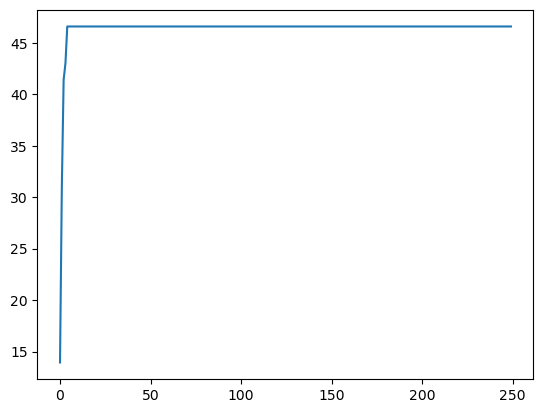

In [37]:
plt.plot(scores)

In [49]:
len(range(0,12500,50))

250

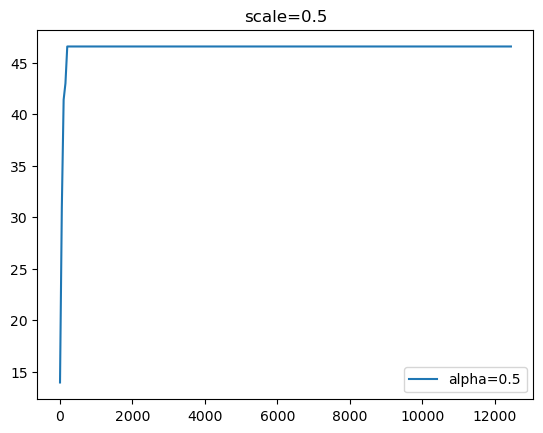

In [50]:
basis_fun = make_radial_basis_network(env,nvec=nvec,scale=scale)#d=)
plt.plot(range(0,12500,50), scores, label=f'alpha={0.5}')#d)

plt.title(f'scale={scale}')#d)
plt.legend()#d)
plt.show()#d)

In [51]:
u,theta,omega = show(Q,env,'theta')

0.024908503311753934
0.09400791769947889
0.20131665383590272
0.3372707045763038
0.4906793706448341
0.6499840903089003
0.8044881614715373
0.9452823210261574
1.065696057499776
1.1612834788648596
1.2294934724874098
1.2692184295891258
1.2804468100575488
1.2684916542186815
1.2371225620075637
1.1877604547202274
1.1223758288444707
1.0435924504057843
0.9547740498282224
0.8600433717957842
0.7641879242517009
0.6724269005147947
0.5900474575832827
0.5219559326663512
0.472216145866989
0.4436522076710955
0.43686494935035336
0.44591800397101716
0.468658277129173
0.5030366805632104
0.5462866990514266
0.5951797633769187
0.646300232655237
0.6963076294668035
0.7421591390981149
0.7812757779420157
0.8116480918079427
0.831888067126387
0.8412403751936546
0.8411696879009315
0.8373641942030622
0.8305886304042727
0.821298865875101
0.810073113008598
0.7975804598457621
0.784544693267087
0.7717047296595878
0.7597734988695264
0.7493976160438719
0.7411204918149198
0.735351568199608
0.7323440717209772
0.7319017218087

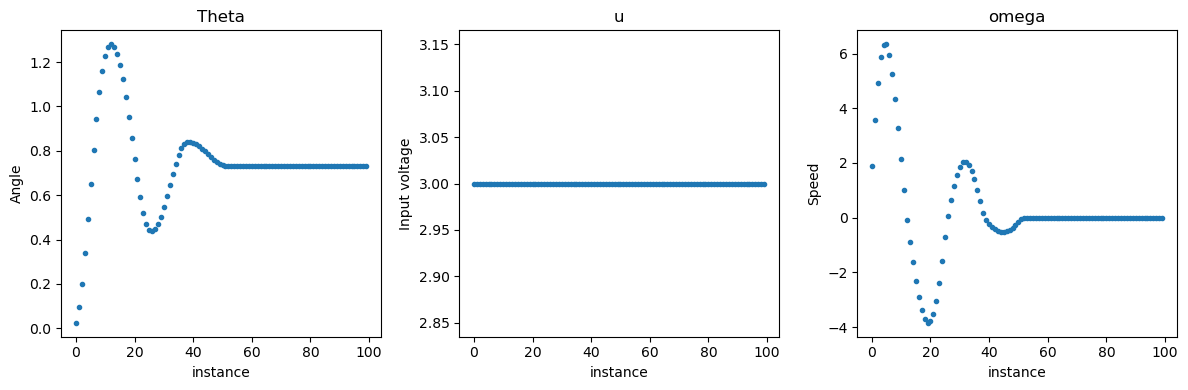

In [52]:
# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot theta
axs[0].plot(theta, '.')
axs[0].set_title('Theta')
axs[0].set_xlabel('instance')
axs[0].set_ylabel('Angle')

# Plot u
axs[1].plot(u, '.')
axs[1].set_title('u')
axs[1].set_xlabel('instance')
axs[1].set_ylabel('Input voltage')

# Plot omega
axs[2].plot(omega, '.')
axs[2].set_title('omega')
axs[2].set_xlabel('instance')
axs[2].set_ylabel('Speed')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [102]:
def make_radial_basis_network(env,nvec,scale):
    # env: is the given enviroment
    # nvec: is the given number of grid points in each dimention.
    # scale: is the sigma_c in the equation
    if isinstance(nvec,int):
        nvec = [nvec]*env.observation_space.shape[0]
    
    # This creates a grid of points c_i the lower bound to the upper bound with nvec number of samples in each dimention
    low, high = env.observation_space.low, env.observation_space.high # get upper and lower bound
    assert np.all(np.isfinite(low)) and np.all(np.isfinite(high)), f'infinite bounds on obersvation space are not permitted low={low}, high={high}'
    Xvec = [np.linspace(l,h,num=ni) for l,h,ni in zip(low,high,nvec)] # calculate the linspace in all directions
    c_points = np.array(np.meshgrid(*Xvec)) # meshgrid all the linspaces together (Nx, X1, X2, X3, ...) 
    c_points = np.moveaxis(c_points, 0, -1) #transform to (X1, X2, X3, ..., Nobs) 
    c_points = c_points.reshape((-1,c_points.shape[-1])) #flatten into the size (Nc, Nobs)
    dx = np.array([X[1]-X[0] for X in Xvec]) # spacing (related to the B matrix)
    
    def basis_fun(obs):
        #this function should return the vector containing all phi_i of all c_points
        obs = np.array(obs) #(Nobs)

        print("c_points",len(c_points),c_points)
        print("obs",len(obs), obs)
        print("dx",len(dx), dx)
        print(c_points.shape)
        print(obs.shape)
        print(dx.shape)
        print()
        print(obs[None,:])
        print(c_points-obs[None,:])
        dis = (c_points-obs[None,:])/dx[None,:] #dim = (Nbasis, Nobs)
        exp_arg = np.sum(dis**2,axis=1)/(2*scale**2) #squared distance to every point #b)
        Z = -exp_arg+np.min(exp_arg) #b) for numerical stability you can add the minimum.
        R = np.exp(Z) #b)
        return R/np.sum(R) #b)
    
    return basis_fun #returns a basis function

In [103]:
basis_fun = make_radial_basis_network(env,nvec=nvec,scale=scale)#d=)
# env.set_discrete_values(discrete_size = 9, minmax = 3.0, div = 2.5, rnd = 2)

In [104]:
visualize_theta(env, theta, basis_fun) #d)

c_points 1000 [[ -1.          -1.         -40.        ]
 [ -1.          -1.         -31.11111111]
 [ -1.          -1.         -22.22222222]
 ...
 [  1.           1.          22.22222222]
 [  1.           1.          31.11111111]
 [  1.           1.          40.        ]]
obs 2 [-1. -1.]
dx 3 [0.22222222 0.22222222 8.88888889]
(1000, 3)
(2,)
(3,)

[[-1. -1.]]


ValueError: operands could not be broadcast together with shapes (1000,3) (1,2) 